# GROUP 7 - STOCK PREDICTION MODEL
Group Members:
1. Aamil Khan Mahar
2. Hamza Shakeel 
3. Taha Hussain
4. Rameel Imran
5. Ahmed Zubair

In [26]:
prediction = False ## Set this to True to run the training and prediction cells

In [27]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import keras
import os
import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_context("notebook")
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.models import load_model
import torch

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")
file_path_1 = '/content/drive/MyDrive/ProjectDS/fundamentals.csv'
file_path_4 = '/content/drive/MyDrive/ProjectDS/securities.csv'
file_path_3 = '/content/drive/MyDrive/ProjectDS/prices-split-adjusted.csv'
file_path_2 = '/content/drive/MyDrive/ProjectDS/prices.csv'
neon_colors = [
    "#FF6EC7",  # Neon Pink
    "#00FFFF",  # Electric Cyan
    "#00FF00",  # Lime Green
    "#FF00FF",  # Hot Magenta
    "#FFA500",  # Fluorescent Orange
    "#4169E1",  # Royal Blue
    "#FFFF00",  # Shocking Yellow
    "#9B30FF",  # Radiant Purple
    "#00CED1",  # Dark Turquoise
    "#FF4500",  # Atomic Tangerine
    "#FFFF66",  # Laser Lemon
    "#FF4500",  # Vivid Vermilion
    "#FF00FF",  # Fuchsia Flash
    "#00FF00",  # Electric Lime
    "#9400D3",  # Ultra Violet
    "#FF1493",  # Deep Pink
    "#32CD32",  # Lime Green
    "#8A2BE2",  # Blue Violet
    "#FF6347",  # Tomato
    "#1E90FF"   # Dodger Blue
]

GPU is not available.


## Reading File


In [28]:
## Reading all four files
fundamentals = pd.read_csv('fundamentals.csv')
prices = pd.read_csv('prices.csv')
prices_sa = pd.read_csv('prices-split-adjusted.csv')
securities = pd.read_csv('securities.csv')
NYSE = [fundamentals,prices,prices_sa,securities]

## setting the index to the Ticker Symbol and synchronising the index name.
fundamentals = fundamentals.set_index('Ticker Symbol')
securities = securities.set_index('Ticker symbol')
prices.rename(columns = {'symbol':'Ticker Symbol'}, inplace = True)
prices_sa.rename(columns = {'symbol':'Ticker Symbol'}, inplace = True)
prices = prices.set_index(['Ticker Symbol'])
prices_sa = prices_sa.set_index(['Ticker Symbol'])
securities.index.name = "Ticker Symbol"
prices['date'] = pd.to_datetime(prices['date'])
prices_sa['date'] = pd.to_datetime(prices_sa['date'])

## Exploratory Data Analysis

### 1. Prices vs Split-adjusted Prices

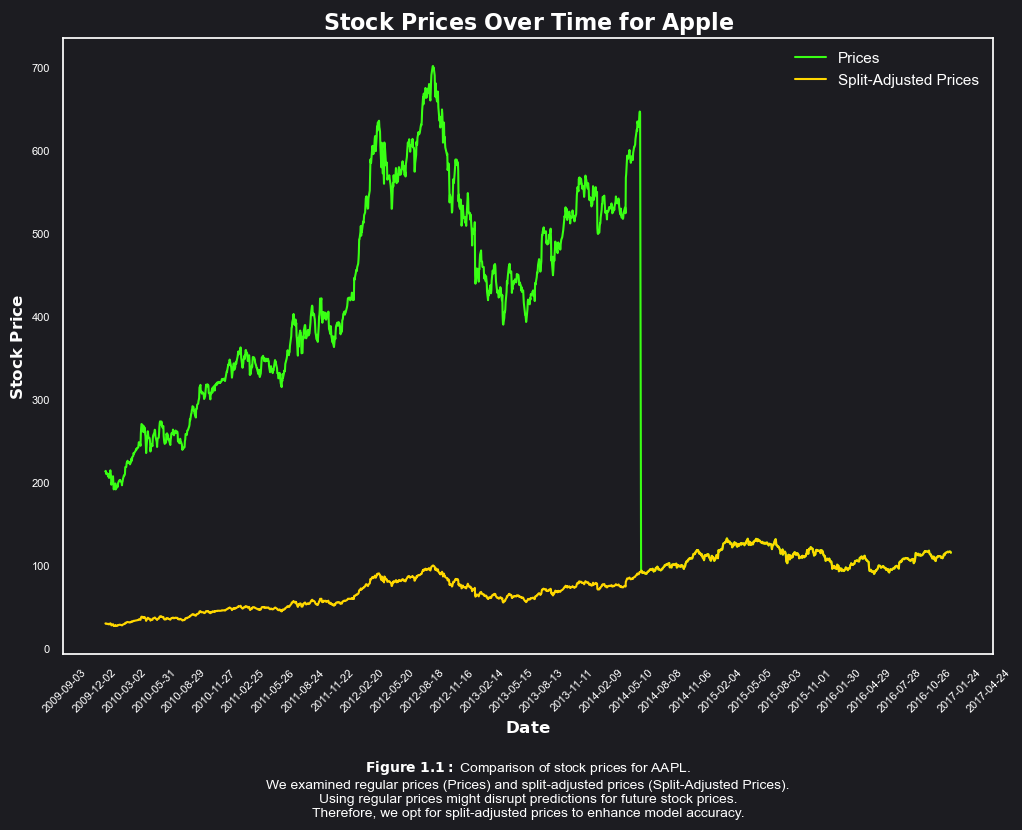

In [29]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
plt.figure(figsize=(12, 8), facecolor='#1C1C21')
# Converting the Dates to a more easier version for readibility and implementation in further code
prices['date'] = pd.to_datetime(prices['date'])
prices_sa['date'] = pd.to_datetime(prices_sa['date'])


# Plotting Two line plots for prices of apple over time, and comparing prices to split-adjusted prices
sns.lineplot(x='date', y='close', data=prices.loc['AAPL'], label='Prices', color='#39FF14')
sns.lineplot(x='date', y='close', data=prices_sa.loc['AAPL'], label='Split-Adjusted Prices', color='#FFD700')

# Formatting the Plot so that they can be used as figures in our blog post as well
sns.set_style("dark")
plt.gca().set_facecolor('#1C1C21') # this is the color of medium hence using that as the background
plt.gca().set_title(r'$\bf{Stock\ Prices\ Over\ Time\ for\ Apple}$', fontsize=16, color='white')  
plt.xlabel(r'$\bf{Date}$', color='white')  
plt.ylabel(r'$\bf{Stock\ Price}$', color='white') 
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('white')
legend.get_frame().set_facecolor('#1C1C21')  
legend.get_frame().set_linewidth(0)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=90))
plt.xticks(rotation=45, color='white')  
plt.tick_params(axis='x', which='both', labelsize=8, colors='white')
plt.tick_params(axis='y', which='both', labelsize=8, colors='white')  
plt.text(0.5, -0.22, 
         r'$\bf{Figure\ 1.1}:$' ' Comparison of stock prices for AAPL.\n'
         'We examined regular prices (Prices) and split-adjusted prices (Split-Adjusted Prices).\n'
         'Using regular prices might disrupt predictions for future stock prices.\n'
         'Therefore, we opt for split-adjusted prices to enhance model accuracy.', 
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, color='white')

plt.show()



### 2. Sector Analysis
#### Figure 2.1 - Average Sector Stock Price over Time


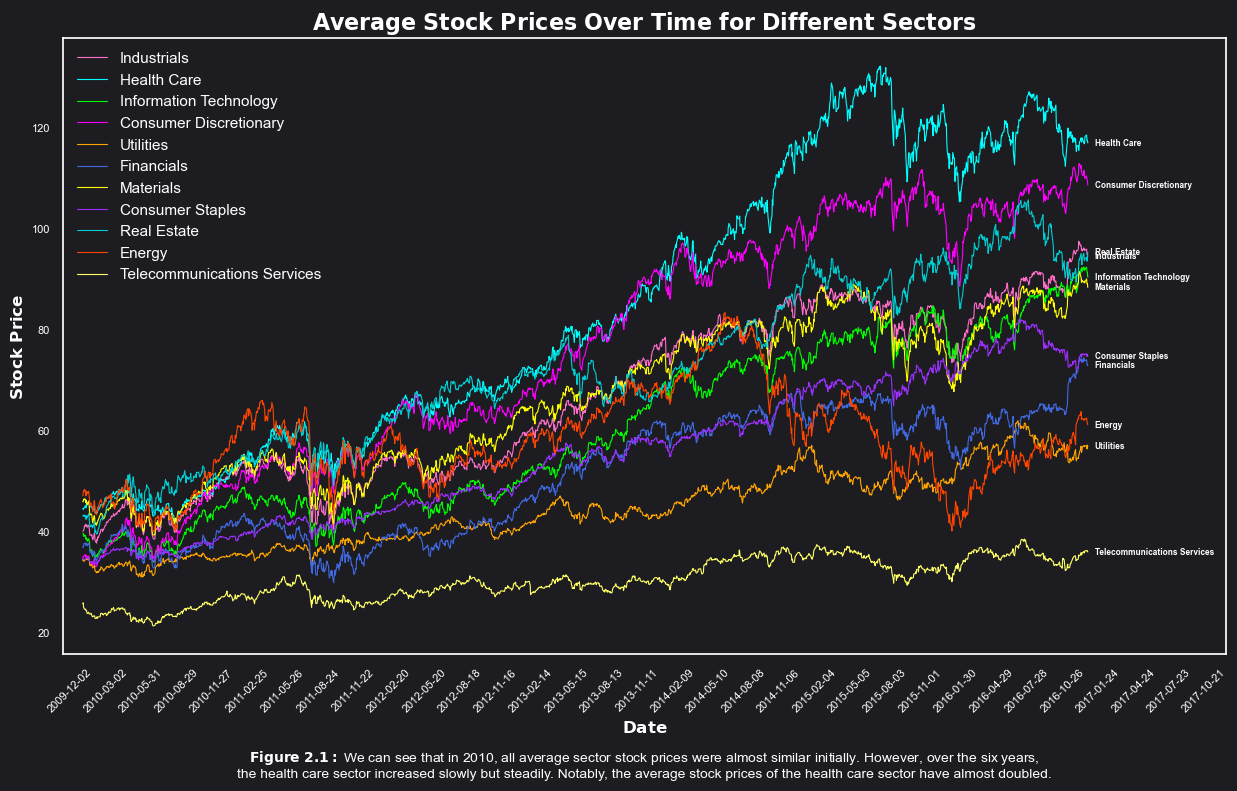

In [30]:
from datetime import timedelta
# combining sectors with prices_sa
prices_sa = pd.merge(prices_sa, securities['GICS Sector'], left_index=True, right_index=True)
# code
average_prices_pivoted = prices_sa.pivot_table(index='date', columns='GICS Sector', values='close', aggfunc='mean')
average_prices_pivoted
sectors = securities['GICS Sector'].unique().tolist()
plt.figure(figsize=(15,8), facecolor='#1C1C21')
for sector in sectors:
    sns.lineplot(x='date', y=sector, data=average_prices_pivoted, label=sector,linewidth = 0.8, color=neon_colors[sectors.index(sector)])
    last_value = average_prices_pivoted[sector].dropna().iloc[-1]
    plt.annotate(sector, xy=(average_prices_pivoted.index[-1], last_value), xytext=(5,0), textcoords='offset points',
                 color='white', fontsize=6, fontweight='bold', ha='left', va='center', clip_on=True)

# plot formatting
plt.xlim(average_prices_pivoted.index.min()-timedelta(days=50), average_prices_pivoted.index.max()+timedelta(days=350))
plt.gca().set_facecolor('#1C1C21') # this is the color of medium hence using that as the background
plt.gca().set_title(r'$\bf{Average\ Stock\ Prices\ Over\ Time\ for\ Different\ Sectors}$', fontsize=16, color='white')  
plt.xlabel(r'$\bf{Date}$', color='white')  
plt.ylabel(r'$\bf{Stock\ Price}$', color='white') 
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('white')
legend.get_frame().set_facecolor('#1C1C21')  
legend.get_frame().set_linewidth(0)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=90))
plt.xticks(rotation=45, color='white')  
plt.tick_params(axis='x', which='both', labelsize=8, colors='white')
plt.tick_params(axis='y', which='both', labelsize=8, colors='white')
plt.text(0.5, -0.18, 
         r'$\bf{Figure\ 2.1}:$' ' We can see that in 2010, all average sector stock prices were almost similar initially. However, over the six years,\nthe health care sector increased slowly but steadily. Notably, the average stock prices of the health care sector have almost doubled.', 
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, color='white')
plt.show()


#### Figure 2.2 - Correlation between Sectors

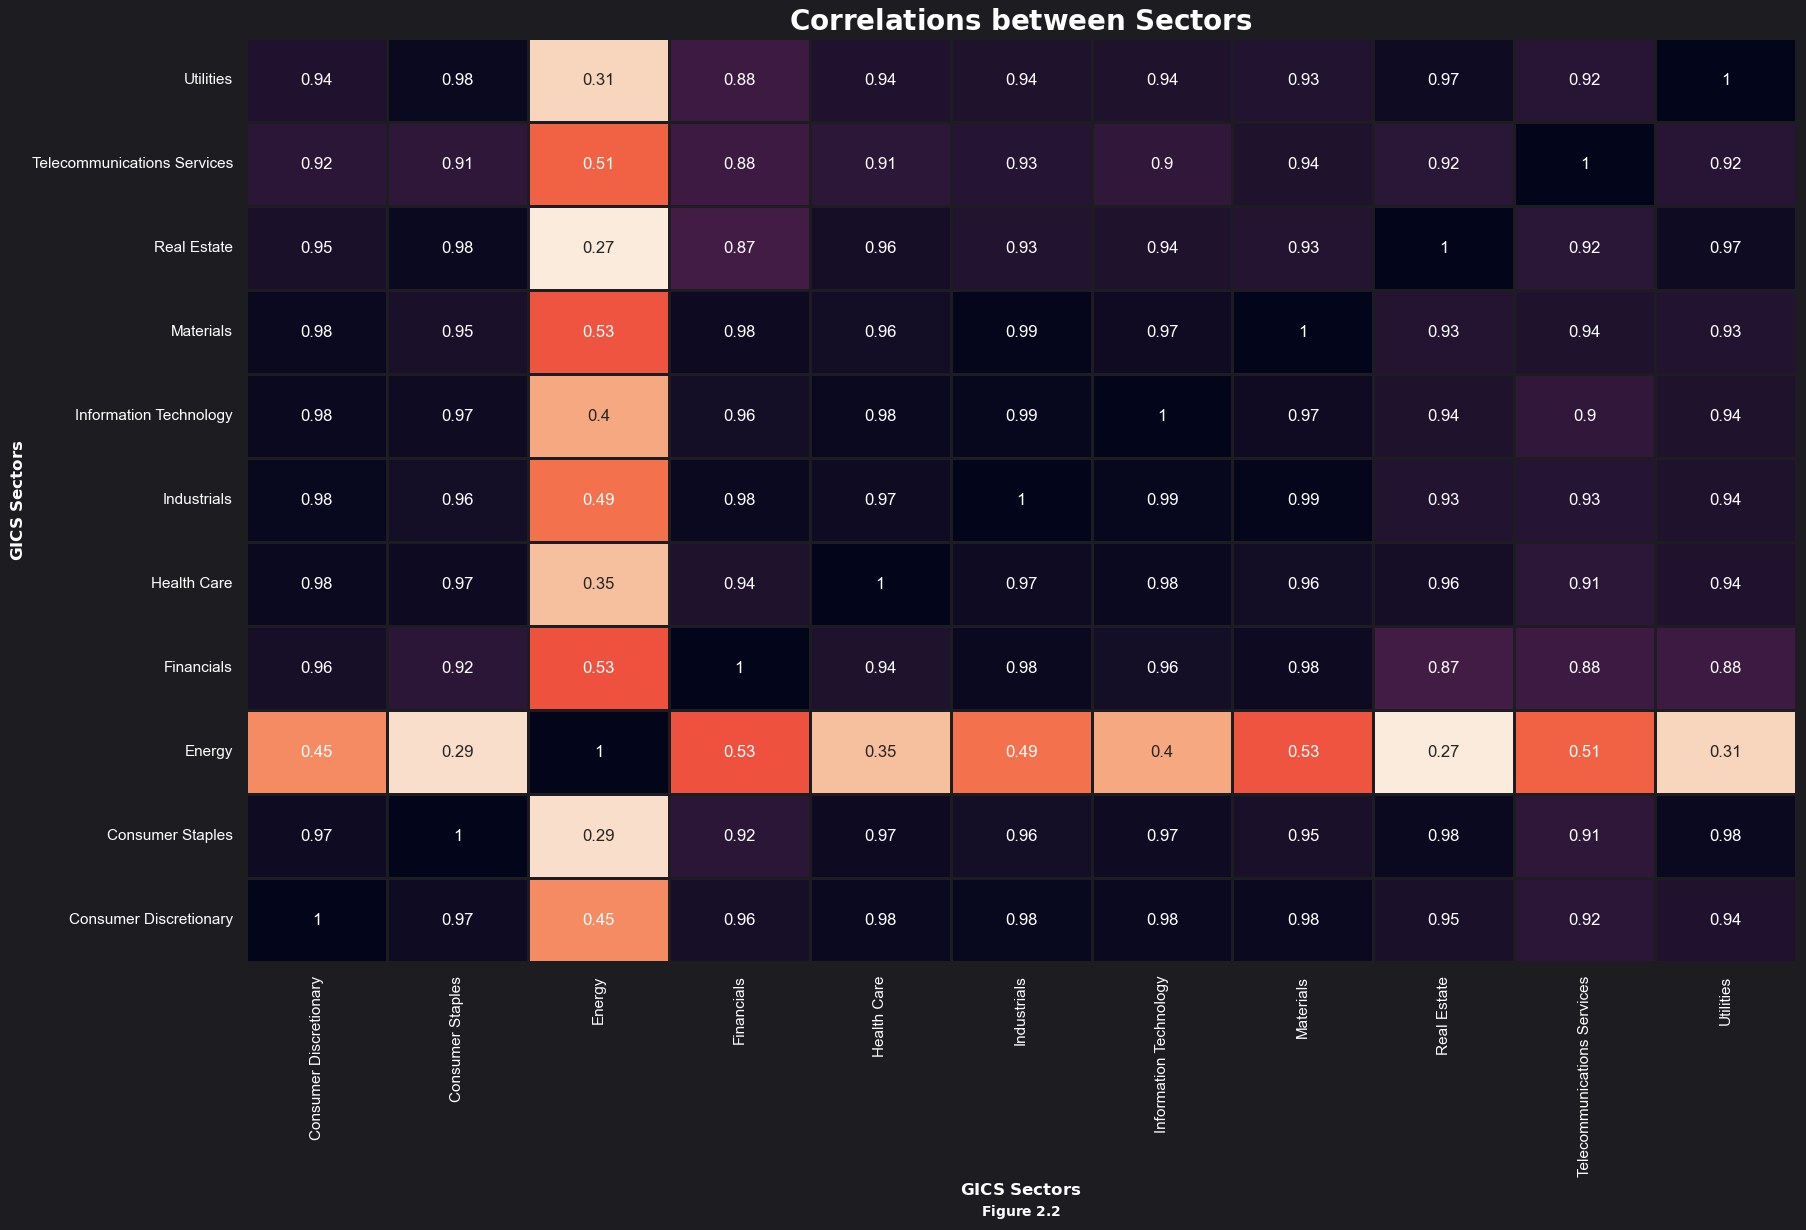

In [31]:
from matplotlib.colors import ListedColormap
average_prices_pivoted
plt.figure(figsize=(20,12), facecolor='#1C1C21')

sns.heatmap(average_prices_pivoted.corr(), annot=True, cmap='rocket_r',linecolor= '#1C1C21', linewidths=1, cbar = False).invert_yaxis()


plt.gca().set_facecolor('#1C1C21') # this is the color of medium hence using that as the background
plt.gca().set_title(r'$\bf{Correlations\ between\ Sectors}$', fontsize=20, color='white')  
plt.xlabel(r'$\bf{GICS\ Sectors}$',fontweight ='bold', color='white')
plt.ylabel(r'$\bf{GICS\ Sectors}$',fontweight ='bold', color='white')  
plt.tick_params(axis='x', which='both', labelsize=11, colors='white')
plt.tick_params(axis='y', which='both', labelsize=11, colors='white')
plt.text(0.5, -0.27, 
         r'$\bf{Figure\ 2.2}$', 
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, color='white')
plt.show()

#### Figure 2.3 - Average Returns and Risk of Each Sector (Manual Return Calulation)

In [32]:
returns_sa = prices_sa[['date','close','GICS Sector']]
returns_sa = returns_sa.sort_values(by = ['Ticker Symbol','date'])
returns_sa['daily_return'] = returns_sa.groupby('Ticker Symbol')['close'].pct_change()
returns_sa = returns_sa.dropna()
returns_sa

Expectation = pd.DataFrame(returns_sa.groupby('Ticker Symbol')['daily_return'].mean())
Expectation['Risk'] = returns_sa.groupby('Ticker Symbol')['daily_return'].std()
Expectation = Expectation.rename(columns={'daily_return':'Expected Return'})
Expectation.transpose()


Ticker Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XLNX,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS
Expected Return,0.00058,0.001764,0.000961,0.000893,0.000724,0.000700,0.000287,0.000681,0.000739,0.000599,...,0.000622,0.000223,0.000369,0.000182,0.000686,0.000647,0.000643,0.000409,0.000897,0.000669
Risk,0.01876,0.030713,0.017214,0.016518,0.017299,0.013233,0.011658,0.014082,0.017784,0.016019,...,0.016097,0.011993,0.013420,0.018640,0.014304,0.019162,0.015419,0.014202,0.021494,0.015195


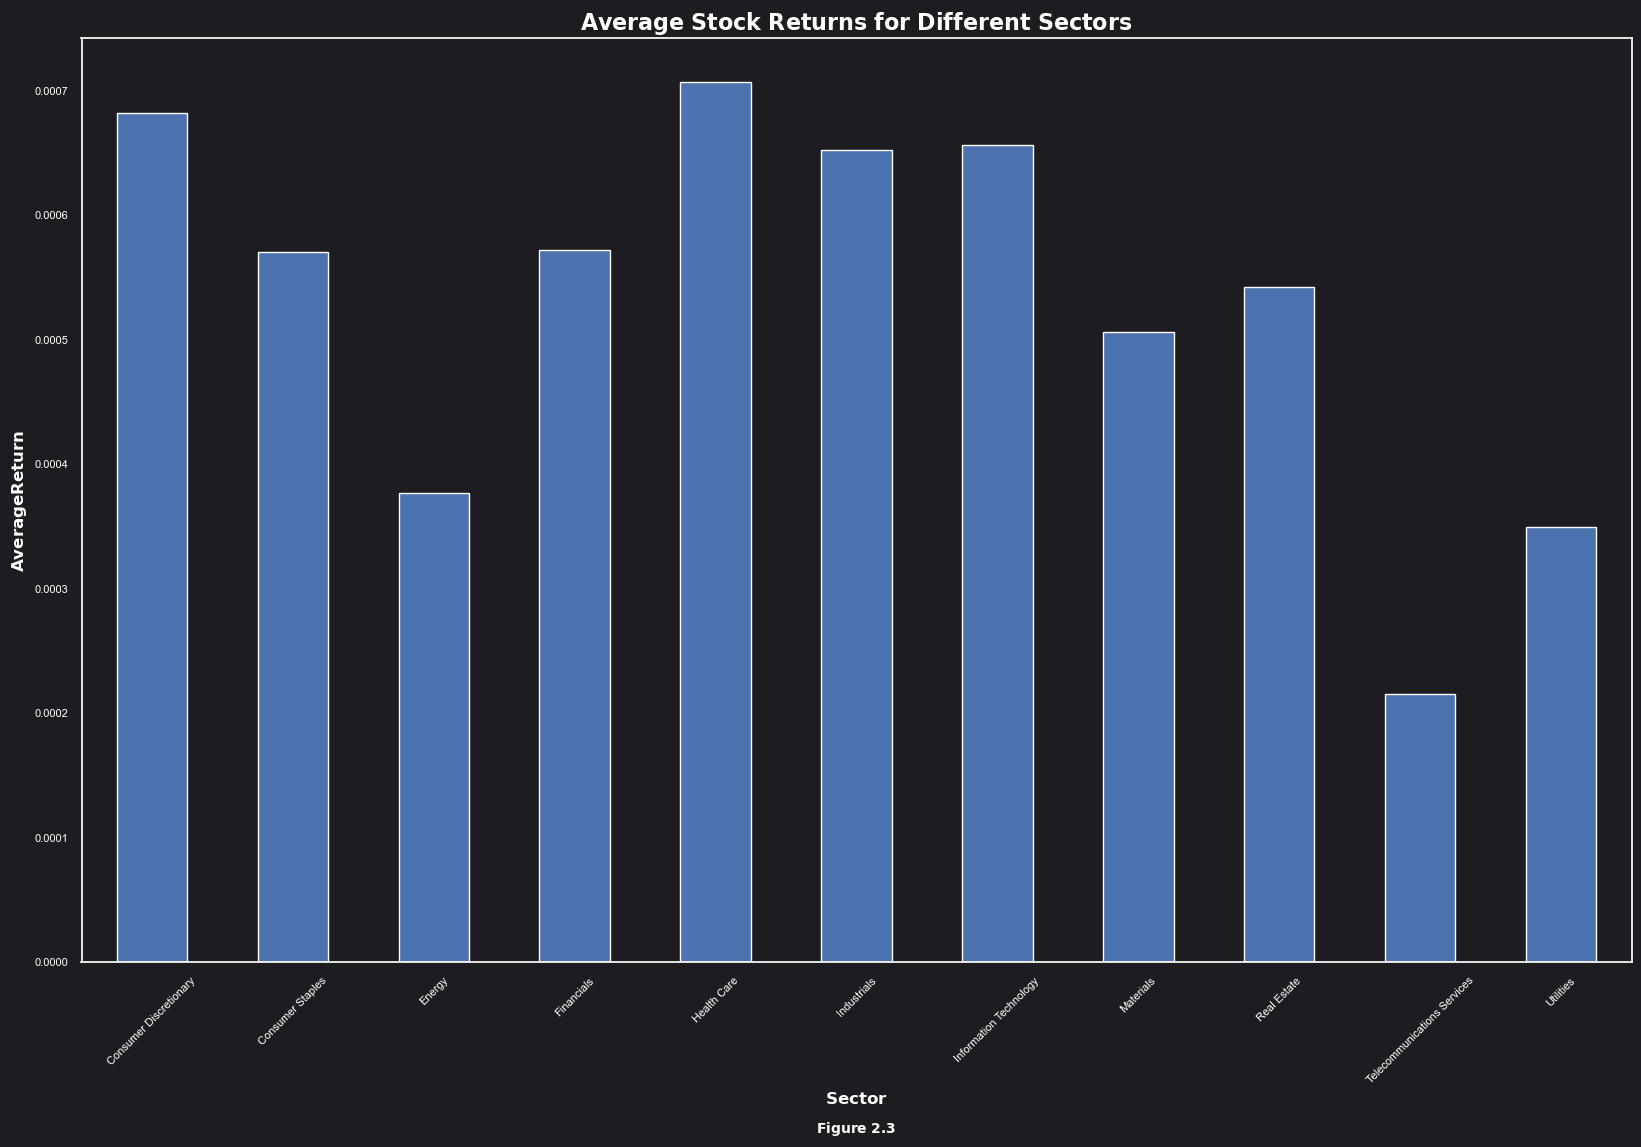

In [33]:
average_returns_by_sector = returns_sa.groupby(['GICS Sector'])['daily_return'].mean()
average_returns_by_sector
plt.figure(figsize=(20,12), facecolor='#1C1C21')
average_returns_by_sector.plot(kind='bar', stacked=True)
plt.gca().set_facecolor('#1C1C21') # this is the color of medium hence using that as the background
plt.gca().set_title(r'$\bf{Average\ Stock\ Returns\ for\ Different\ Sectors}$', fontsize=16, color='white')  
plt.xlabel(r'$\bf{Sector}$', color='white')  
plt.ylabel(r'$\bf{Average Return}$', color='white') 
plt.xticks(rotation=45, color='white')  
plt.tick_params(axis='x', which='both', labelsize=8, colors='white')
plt.tick_params(axis='y', which='both', labelsize=8, colors='white')
plt.text(0.5, -0.18, 
         r'$\bf{Figure\ 2.3}$',
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, color='white')
plt.show()

### Fundamentals
#### Figure 3.1 - Feature Engineering(Financial Analysis) - Removing similar variables 

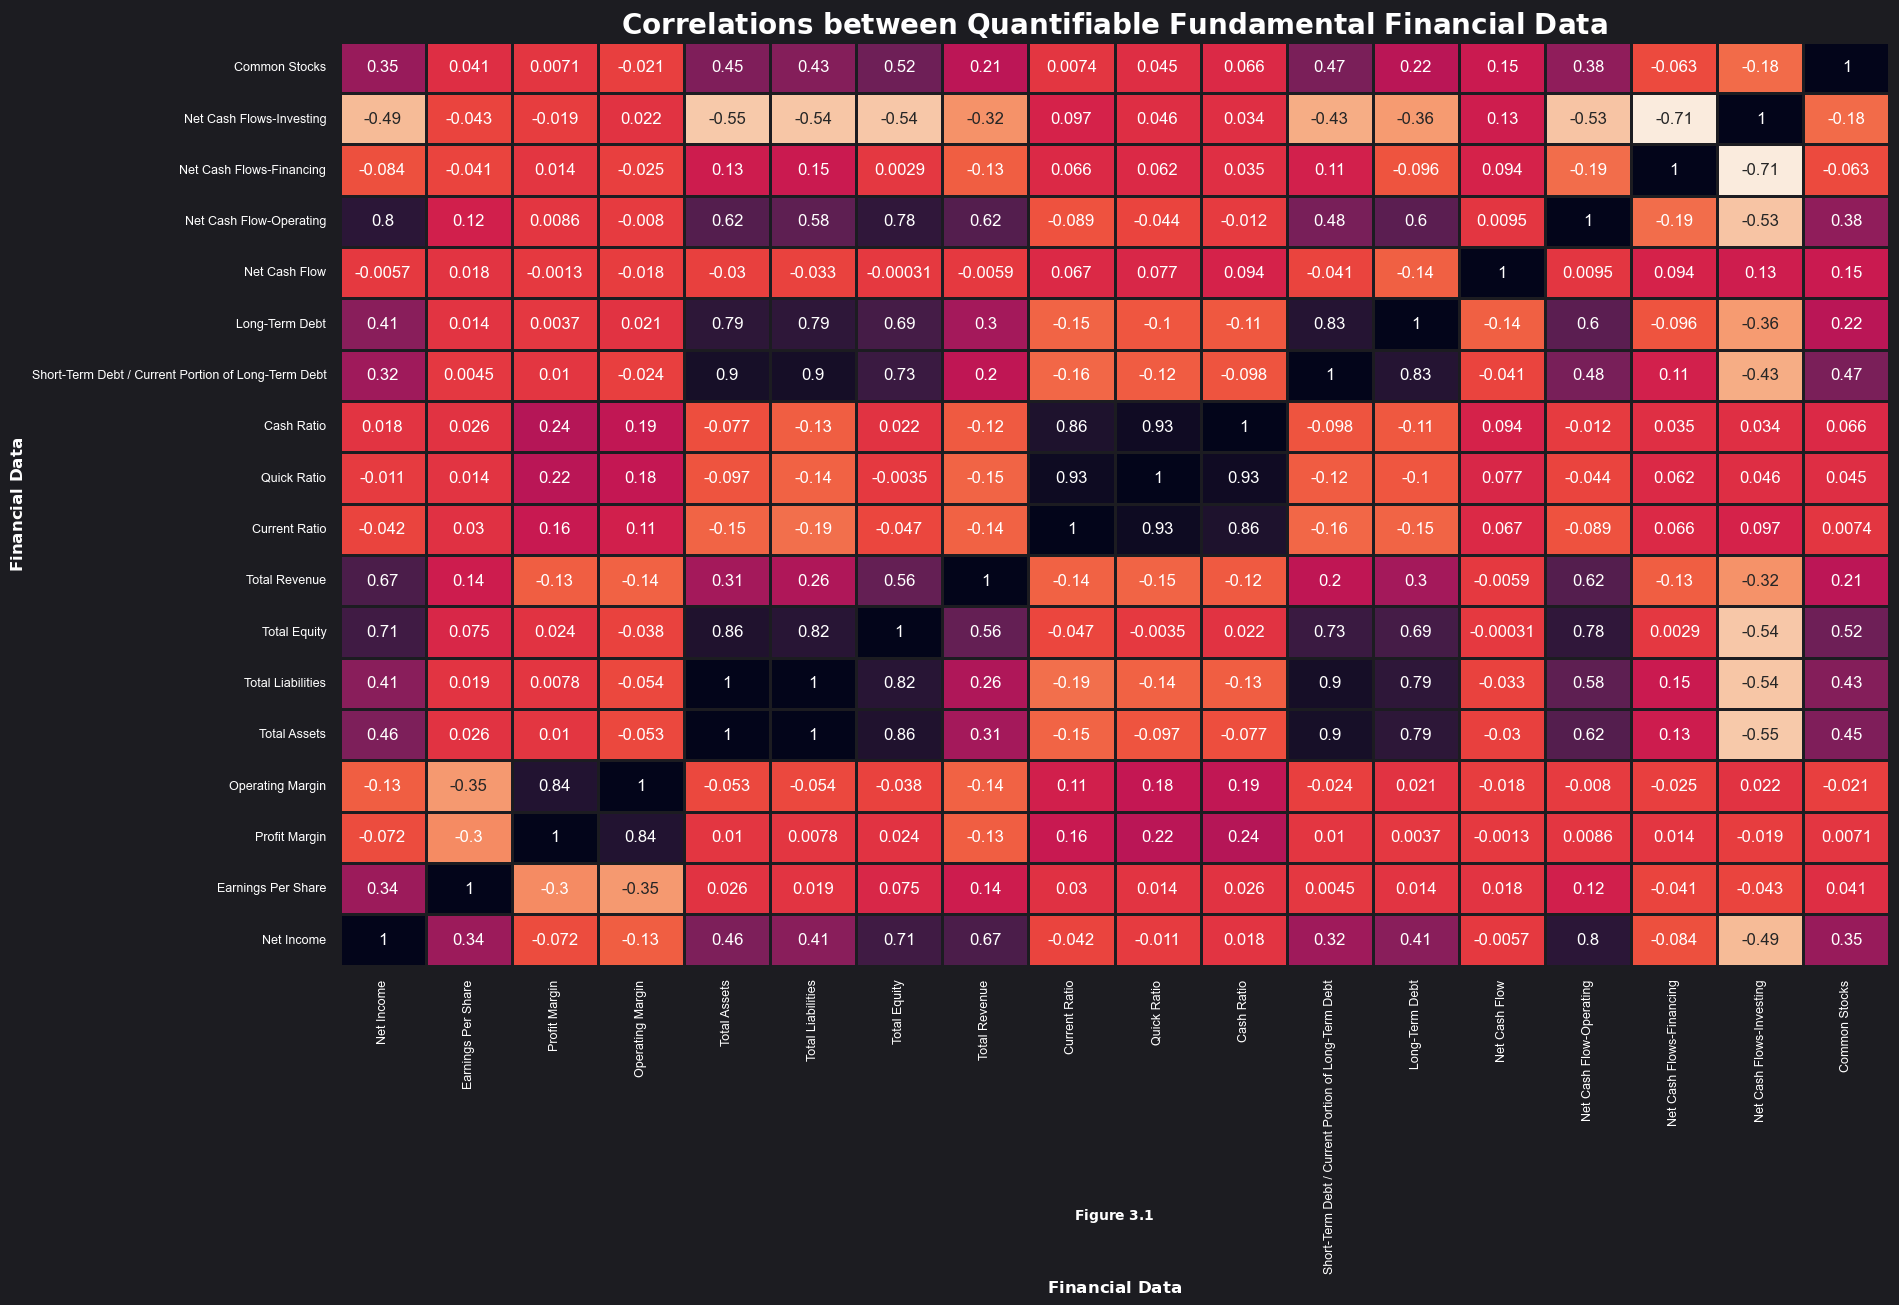

In [34]:
data = fundamentals.iloc[:, 3:]
data.columns
selected_variables = [ 'Period Ending', 'Net Income', 'Earnings Per Share', 
                       'Profit Margin', 'Operating Margin', 'Total Assets',
                       'Total Liabilities', 'Total Equity', 'Total Revenue', 'Current Ratio', 'Quick Ratio',
                       'Cash Ratio', 'Short-Term Debt / Current Portion of Long-Term Debt', 'Long-Term Debt',
                       'Net Cash Flow', 'Net Cash Flow-Operating', 'Net Cash Flows-Financing',
                       'Net Cash Flows-Investing', 'Common Stocks']

fundamentals_filtered = fundamentals[selected_variables]
choosen_columns = fundamentals_filtered.select_dtypes(include=np.number)
correlation_matrix = choosen_columns.corr()
plt.figure(figsize=(20,12),facecolor='#1C1C21')
sns.set(style="dark")
sns.heatmap(correlation_matrix, annot=True, cmap='rocket_r',linecolor= '#1C1C21', linewidths=1, cbar = False).invert_yaxis()
plt.gca().set_facecolor('#1C1C21') # this is the color of medium hence using that as the background
plt.gca().set_title(r'$\bf{Correlations\ between\ Quantifiable\ Fundamental\ Financial\ Data}$', fontsize=20, color='white')  
plt.xlabel(r'$\bf{Financial\ Data}$',fontweight ='bold', color='white')
plt.ylabel(r'$\bf{Financial\ Data}$',fontweight ='bold', color='white')  
plt.tick_params(axis='x', which='both', labelsize=9, colors='white')
plt.tick_params(axis='y', which='both', labelsize=9, colors='white')
plt.text(0.5, -0.27, 
         r'$\bf{Figure\ 3.1}$', 
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, color='white')
plt.show()

### 4. Portfolio Creation
#### Figure 4.1
In this Section we will testing if we are able to calculate our portfolio weights correctly and it also helps us get familiar with the PyPortOpt Library

In [35]:

import pypfopt
from pypfopt import (
    CLA,
    BlackLittermanModel,
    EfficientFrontier,
    HRPOpt,
    black_litterman,
    expected_returns,
    plotting,
    risk_models,)
prices_sa_pivoted = prices_sa.pivot_table(index='date',columns={'Ticker Symbol'},values='close')
returns_py = expected_returns.returns_from_prices(prices_sa_pivoted)
returns_py = returns_py.sort_index()
prices_sa_pivoted = prices_sa_pivoted.dropna(axis=1)
prices_sa_pivoted ##some stocks are droppped because they didnot exist for the whole time period
returns_py = expected_returns.returns_from_prices(prices_sa_pivoted)
returns_py = returns_py.sort_index()
mu = expected_returns.mean_historical_return(prices_sa_pivoted)
mu.name = "E(R)"
mu.to_frame().transpose()




Ticker Symbol,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,...,XEL,XL,XLNX,XOM,XRAY,XRX,YHOO,YUM,ZBH,ZION
E(R),0.107014,0.386023,0.227475,0.209974,0.166647,0.056676,0.157807,0.157301,0.126094,0.054671,...,0.09872,0.103514,0.132017,0.03886,0.072796,0.00165,0.123859,0.140788,0.080646,0.182617


#### Figure 4.2 - This is the covariance matrix, not the correlation matrix, the diagnols are the variance of the asset

In [36]:
covariance_matrix = risk_models.fix_nonpositive_semidefinite(risk_models.sample_cov(prices_sa_pivoted), fix_method = "spectral") 
covariance_matrix

Ticker Symbol,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,...,XEL,XL,XLNX,XOM,XRAY,XRX,YHOO,YUM,ZBH,ZION
Ticker Symbol,,,,,,,,,,,,,,,,,,,,,
A,0.088689,0.054155,0.026321,0.031123,0.027794,0.026362,0.037473,0.042119,0.043408,0.034674,...,0.016196,0.040254,0.039517,0.030028,0.040931,0.047239,0.039425,0.032701,0.035238,0.056327
AAL,0.054155,0.237707,0.031814,0.032764,0.027160,0.025064,0.029208,0.043720,0.041070,0.035047,...,0.015550,0.043535,0.035155,0.020833,0.037357,0.044320,0.040898,0.033979,0.031591,0.061014
AAP,0.026321,0.031814,0.074676,0.015953,0.013670,0.015532,0.016669,0.020578,0.022500,0.019929,...,0.010555,0.020125,0.021398,0.013535,0.019310,0.023081,0.020977,0.022431,0.017831,0.028976
AAPL,0.031123,0.032764,0.015953,0.068754,0.014451,0.014241,0.020883,0.024759,0.027955,0.018199,...,0.008965,0.021838,0.021976,0.017273,0.020478,0.027274,0.024410,0.021991,0.020574,0.031203
ABC,0.027794,0.027160,0.013670,0.014451,0.044129,0.015866,0.016934,0.019507,0.018524,0.016478,...,0.008066,0.020468,0.016515,0.014379,0.019564,0.021579,0.020633,0.015788,0.017237,0.025035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XRX,0.047239,0.044320,0.023081,0.027274,0.021579,0.023447,0.033526,0.036463,0.039366,0.033598,...,0.014794,0.036215,0.037043,0.027973,0.033170,0.087561,0.032642,0.026819,0.030715,0.052154
YHOO,0.039425,0.040898,0.020977,0.024410,0.020633,0.018341,0.026019,0.032892,0.031101,0.026879,...,0.010326,0.027781,0.027691,0.020464,0.025997,0.032642,0.092532,0.025492,0.025247,0.034200
YUM,0.032701,0.033979,0.022431,0.021991,0.015788,0.016310,0.022851,0.027951,0.025481,0.022265,...,0.012177,0.024094,0.022036,0.018941,0.022263,0.026819,0.025492,0.059910,0.019705,0.034051


#### Figure 4.3 - Max Sharpe Portfolio

In [37]:
from collections import OrderedDict
max_sharpe_EF = EfficientFrontier(mu,covariance_matrix,weight_bounds=(0,1),verbose=True)
weights = max_sharpe_EF.max_sharpe()
cleaned_weights = max_sharpe_EF.clean_weights()
max_sharpe_EF.portfolio_performance(verbose=True)
max_sharpe_portfolio = {'Weight':cleaned_weights}
max_sharpe_portfolio = pd.DataFrame(max_sharpe_portfolio)
max_sharpe_portfolio

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 05 11:22:31 PM: Your problem has 468 variables, 5 constraints, and 0 parameters.
(CVXPY) Dec 05 11:22:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 05 11:22:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 05 11:22:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 05 11:22:33 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 05 11:22:33 PM: Compiling problem (target solver=OSQP).
(CV

,Weight
A,0.0
AAL,0.0
AAP,0.0
AAPL,0.0
ABC,0.0
...,...
XRX,0.0
YHOO,0.0
YUM,0.0
ZBH,0.0


#### Figure 4.4 - Global Minimum Variance Portfolio

In [38]:
min_risk_EF = EfficientFrontier(mu,covariance_matrix,weight_bounds=(0,1),verbose=True)
weights = min_risk_EF.min_volatility()
cleaned_weights = min_risk_EF.clean_weights()
min_risk_EF.portfolio_performance(verbose=True)
min_risk_portfolio = {'Weight':cleaned_weights}
min_risk_portfolio = pd.DataFrame(min_risk_portfolio)
min_risk_portfolio

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 05 11:22:36 PM: Your problem has 467 variables, 3 constraints, and 0 parameters.


(CVXPY) Dec 05 11:22:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 05 11:22:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 05 11:22:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 05 11:22:38 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 05 11:22:38 PM: Compiling problem (target solver=OSQP).
(CVXPY) Dec 05 11:22:38 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Dec 05 11:22:38 PM: Applying reduction CvxAttr2Constr
(CVXPY) Dec 05 11:22:38 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Dec 05 11:22:38 PM: 

,Weight
A,0.00000
AAL,0.00000
AAP,0.00000
AAPL,0.00000
ABC,0.02666
...,...
XRX,0.00000
YHOO,0.00000
YUM,0.00000
ZBH,0.00000


#### Figure 4.5 - Target Risk Portfolio

In [39]:
target_risk_EF = EfficientFrontier(mu,covariance_matrix,weight_bounds=(0,1),verbose=True)
weights = target_risk_EF.efficient_risk(0.13)
cleaned_weights = target_risk_EF.clean_weights()
target_risk_EF.portfolio_performance(verbose=True)
target_risk_portfolio = {'Weight':cleaned_weights}
target_risk_portfolio = pd.DataFrame(target_risk_portfolio)
target_risk_portfolio

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 05 11:22:42 PM: Your problem has 467 variables, 4 constraints, and 1 parameters.
(CVXPY) Dec 05 11:22:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 05 11:22:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 05 11:22:44 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 05 11:22:44 PM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 05 11:22:44 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Dec 05 11:22:44 PM: Apply

,Weight
A,0.0
AAL,0.0
AAP,0.0
AAPL,0.0
ABC,0.0
...,...
XRX,0.0
YHOO,0.0
YUM,0.0
ZBH,0.0


#### Figure 4.6 - Efficient Frontier


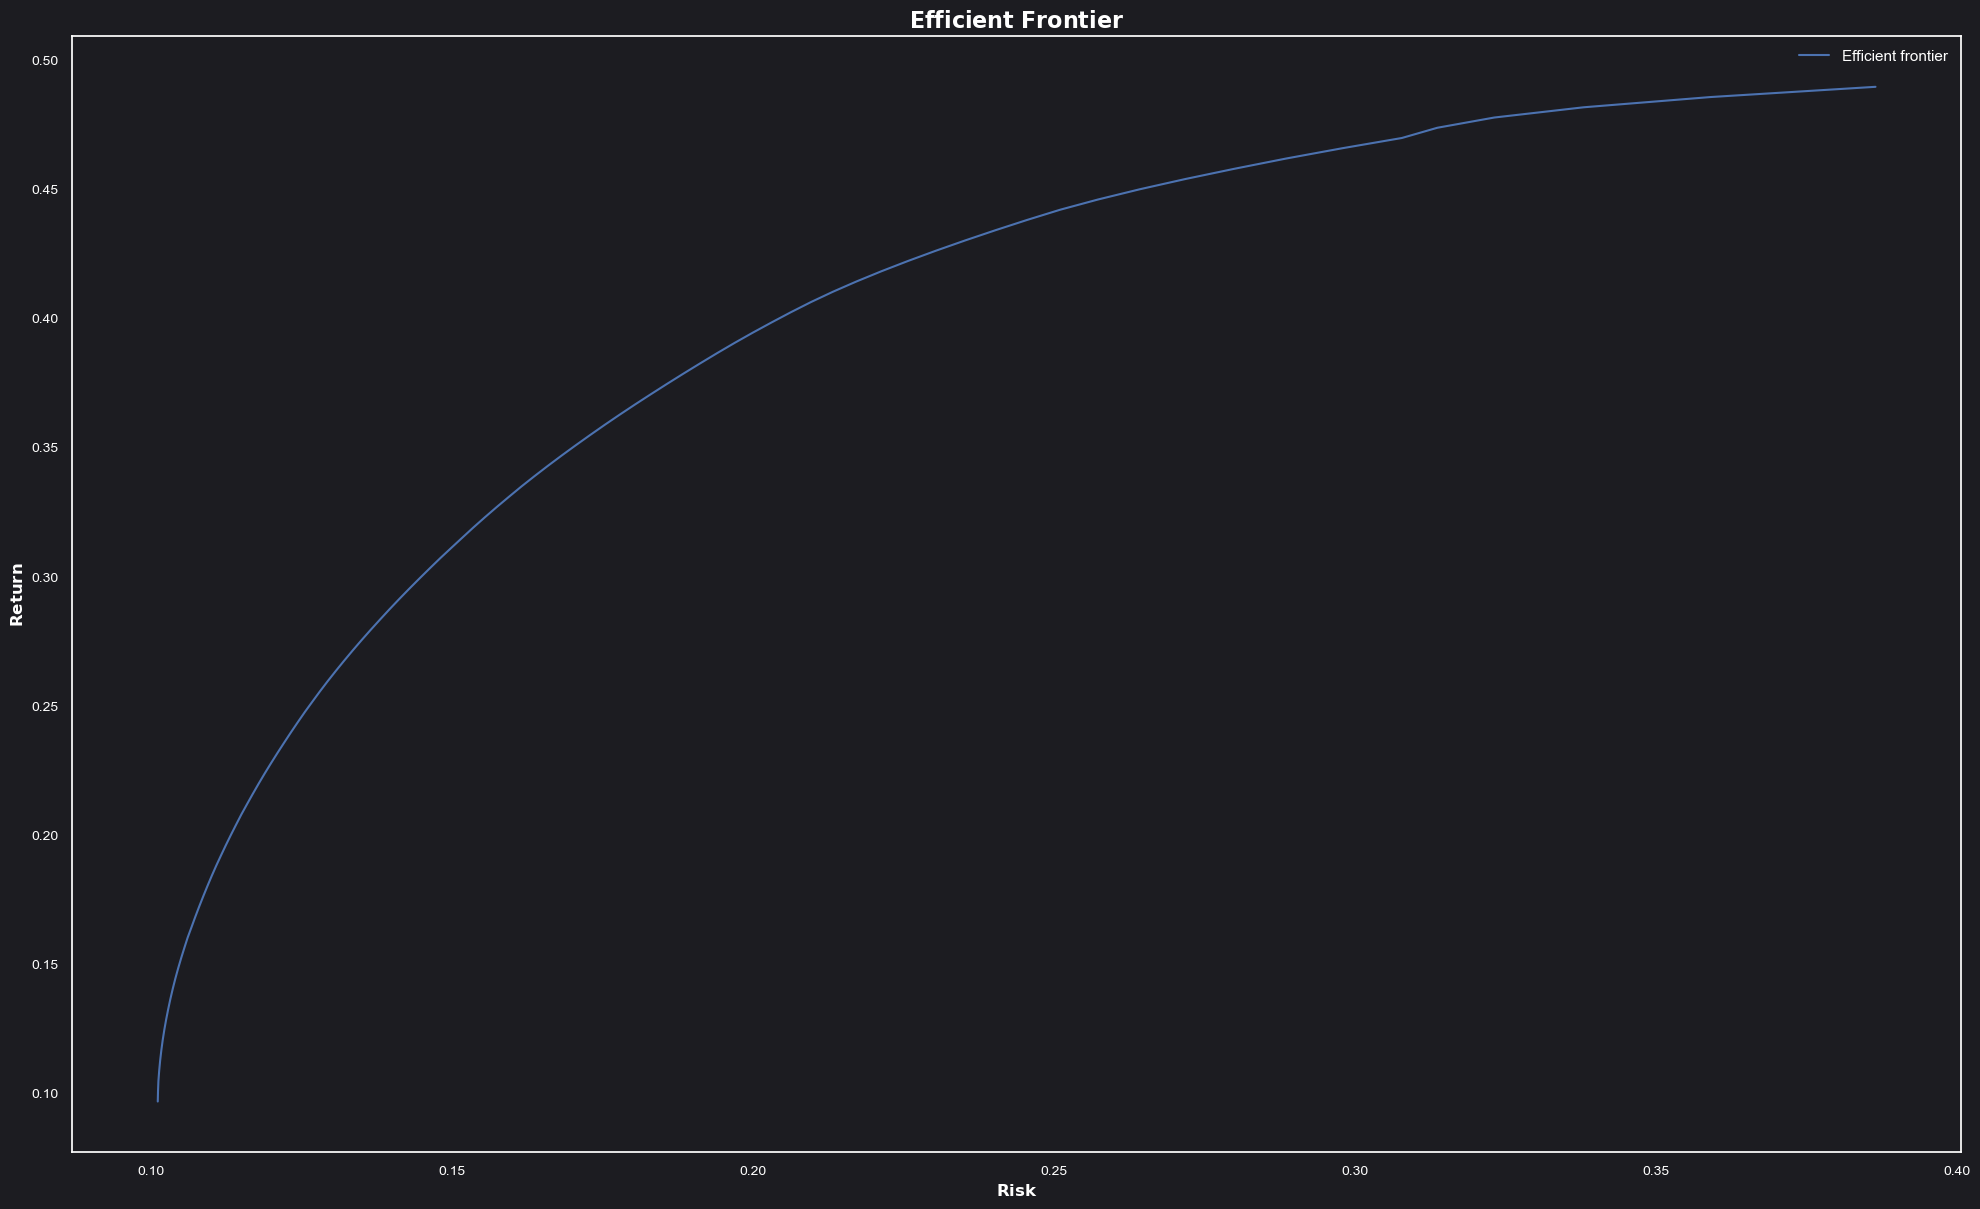

In [40]:
ef = EfficientFrontier(mu,covariance_matrix, weight_bounds=(0, 1))
fig, ax = plt.subplots(figsize=(20, 12), facecolor='#1C1C21')
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False,)

plt.gca().set_facecolor('#1C1C21') # this is the color of medium hence using that as the background
plt.gca().set_title(r'$\bf{Efficient\ Frontier}$', fontsize=16, color='white')  
plt.xlabel(r'$\bf{Risk}$', color='white')  
plt.ylabel(r'$\bf{Return}$', color='white') 
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('white')
legend.get_frame().set_facecolor('#1C1C21')  
legend.get_frame().set_linewidth(0)
plt.tick_params(axis='x', which='both', labelsize=10, colors='white')
plt.tick_params(axis='y', which='both', labelsize=10, colors='white')
plt.show()

## END OF EDA


# x---------------------------------x

# STOCK PREDICTIONS


### 1. Setting Up the Model

In [41]:
prices_sa_pivot = prices_sa.pivot_table(index = 'date', columns='Ticker Symbol' , values = 'close')
prices_sa_pivot.dropna(axis=1, inplace= True) ## 501 - 467 Columns Before Cleaning - Dropping Stocks with Missing Prices in between.

Stocklist = prices_sa_pivot.columns # Stocks to test 
prices_sa_pivot = prices_sa_pivot # 1762 total - 1700 train 31 test
prices_sa_train = pd.DataFrame(prices_sa_pivot.iloc[:1700,:])
prices_sa_test = pd.DataFrame(prices_sa_pivot.iloc[1700:,:])
prices_sa_total = pd.DataFrame(prices_sa_pivot)
prices_sa_total.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21',
               '2016-12-22', '2016-12-23', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='date', length=1762, freq=None)

### 2. LSTM Training Model

In [42]:
if (prediction):
    folder_path = '/content/drive/MyDrive/ProjectDS/Models/'
    models = []
    count = 0
    current_Stocklist = Stocklist
    for name in Stocklist:
        print(count,".Name: ",name)
        dataset_train = prices_sa_train[name]
        training_set = dataset_train.values.reshape(-1,1)
        sc = MinMaxScaler(feature_range=(0,1))
        training_set_scaled = sc.fit_transform(training_set)
        X_train = []
        y_train = []
        for i in range(60, 1700):
            X_train.append(training_set_scaled[i-60:i, 0])
            y_train.append(training_set_scaled[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        model = Sequential()
        model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50,return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50,return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
        model.compile(optimizer='adam',loss='mean_squared_error')
        model.fit(X_train,y_train,epochs=50,batch_size=32)
        model.save(folder_path + name)
        print(f"Model '{name}' saved successfully.")
        models.append(model)
        count = count + 1
else:
    print ("Model Already Trained")

Model Already Trained


### 3. Predicting Stock Prices Using Trained Models

In [43]:
if (prediction):
    folder_path = '/content/drive/MyDrive/ProjectDS/Models/'
    current_Stocklist = pd.Series(Stocklist)

    predicted_prices_df = pd.DataFrame()
    loss_rmse_df = pd.DataFrame(columns=['Stock', 'Loss', 'RMSE'])

    for name in current_Stocklist:
        model_path = folder_path + name
        model = load_model(model_path)
        dataset_train = prices_sa_train[name]
        training_set = dataset_train.values.reshape(-1, 1)
        dataset_test = prices_sa_test[name]
        real_stock_price = dataset_test.values.reshape(-1, 1)
        dataset_total = pd.concat((dataset_train, dataset_test), axis=0)
        inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
        inputs = inputs.reshape(-1, 1)
        sc = MinMaxScaler(feature_range=(0, 1))
        training_set_scaled = sc.fit_transform(training_set)
        inputs = sc.transform(inputs)
        
        X_test = []
        y_test = []

        for i in range(60, 122):
            X_test.append(inputs[i-60:i, 0])
            y_test.append(inputs[i, 0])

        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        y_test = np.asarray(y_test).reshape(-1, 1)
        y_test_original = sc.inverse_transform(y_test)

        predicted_stock_price = model.predict(X_test)
        predicted_stock_price_original = sc.inverse_transform(predicted_stock_price)

        predicted_prices_df[name] = predicted_stock_price_original.flatten()

        loss = model.evaluate(X_test, y_test, verbose=0)
        rmse = np.sqrt(np.mean(((predicted_stock_price_original - y_test_original) ** 2)))

        loss_rmse_df = loss_rmse_df.append({'Stock': name, 'Loss': loss, 'RMSE': rmse}, ignore_index=True)

    print("Predicted Prices DataFrame:")
    print(predicted_prices_df)

    print("\nLoss and RMSE DataFrame:")
    print(loss_rmse_df)

    predicted_prices_df.to_csv('/content/drive/MyDrive/ProjectDS/Results/predicted_prices.csv', index=False)
    loss_rmse_df.to_csv('/content/drive/MyDrive/ProjectDS/Results/loss.csv', index=False)
else:
    print("Prices already predicted")

Prices already predicted


### 4. Comparing Predicted with Actual Prices

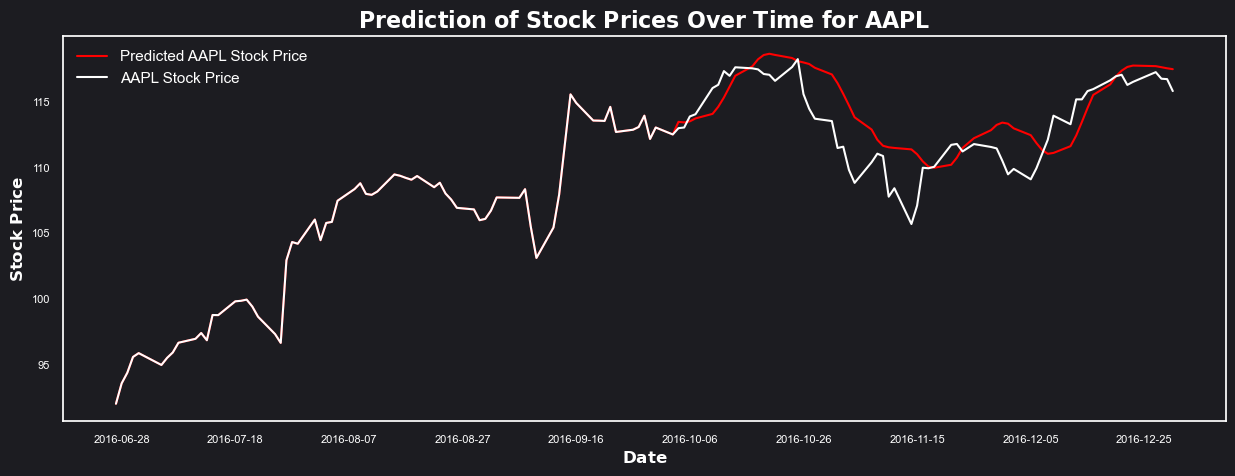

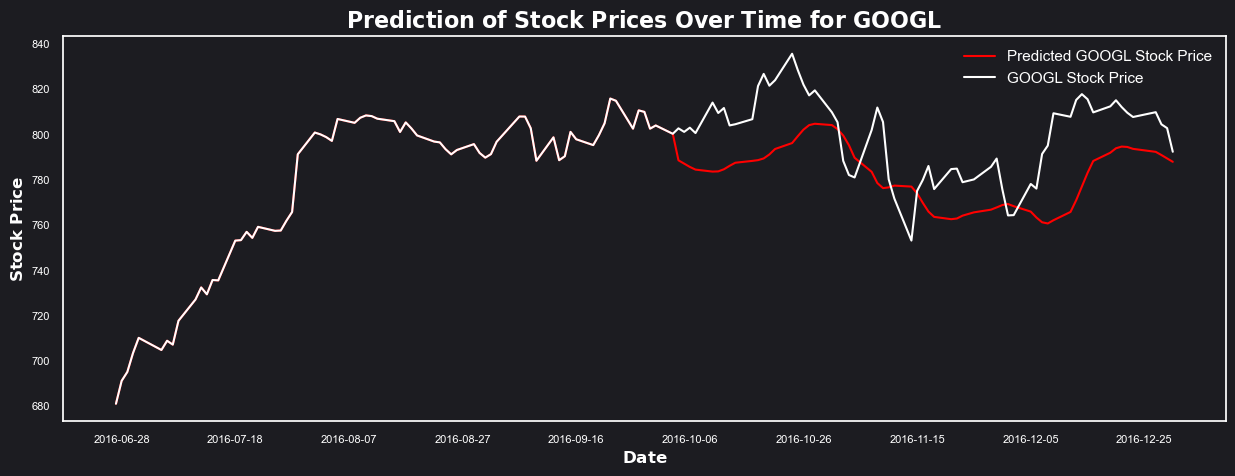

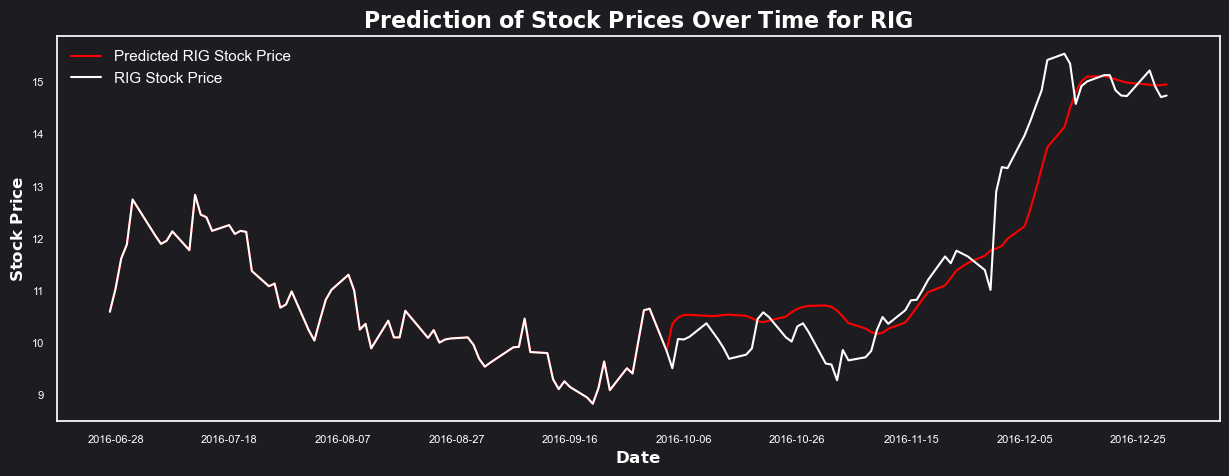

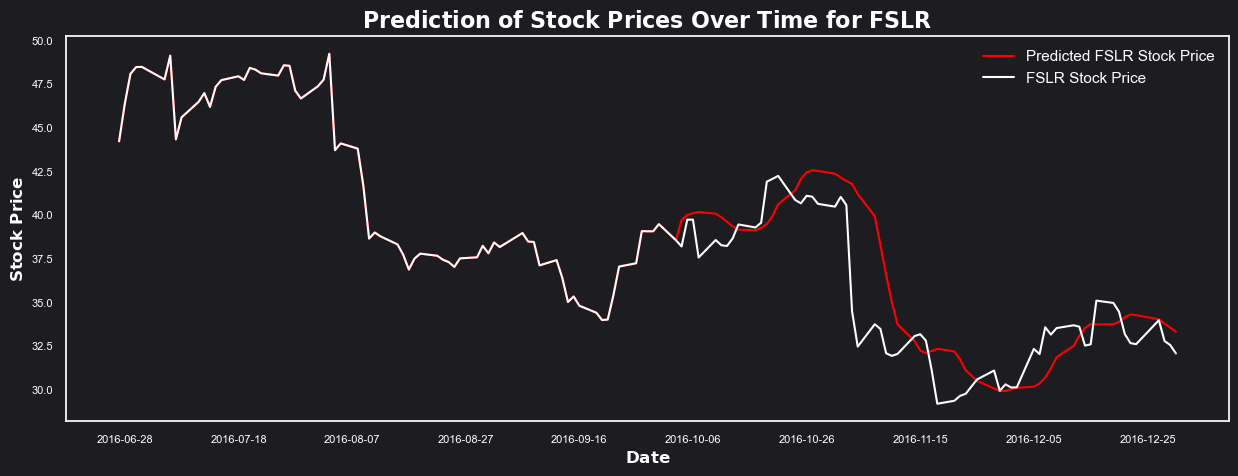

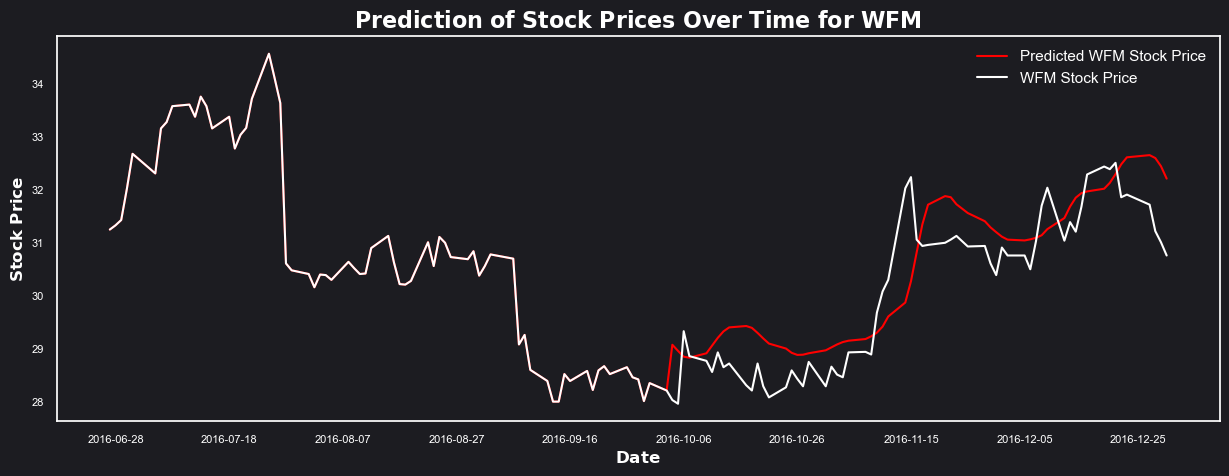

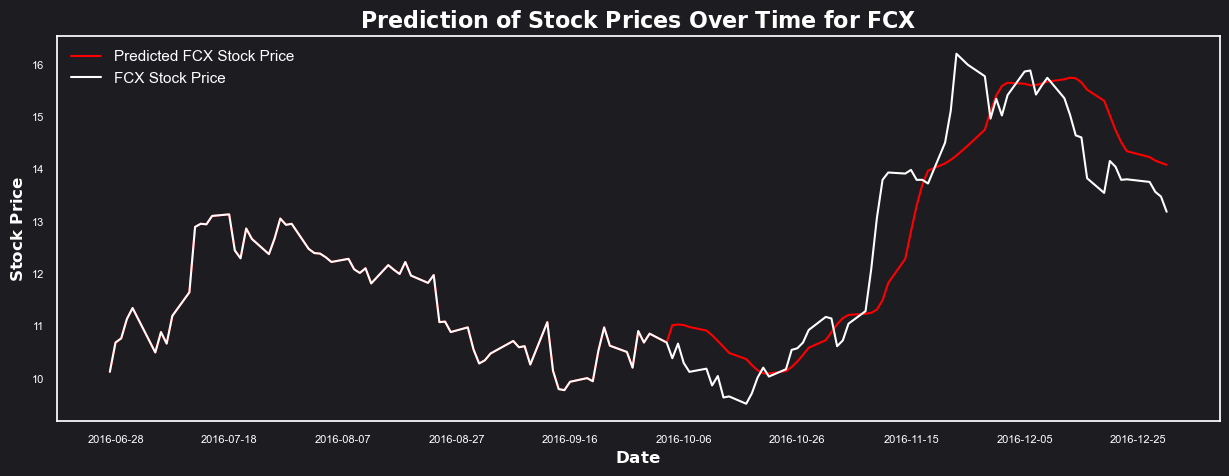

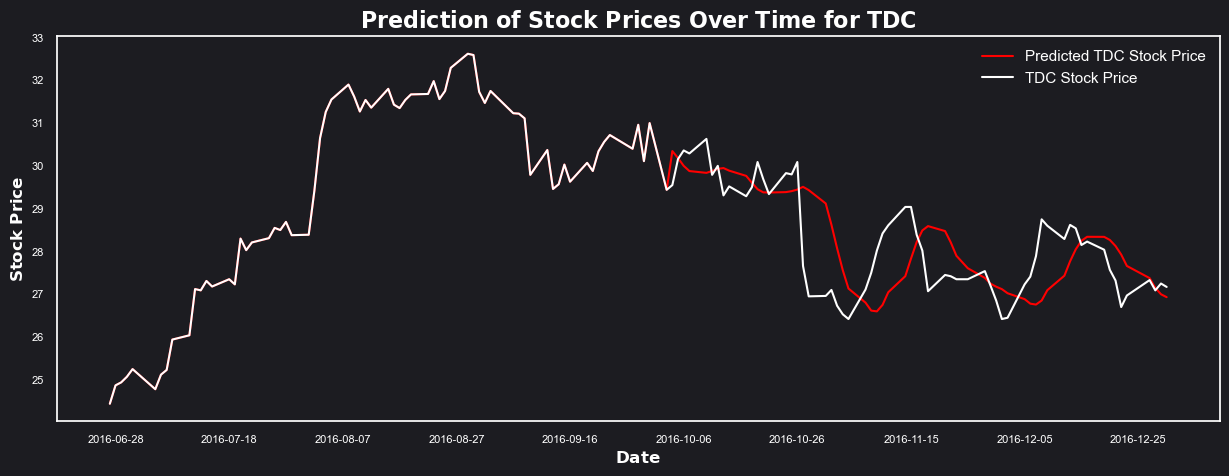

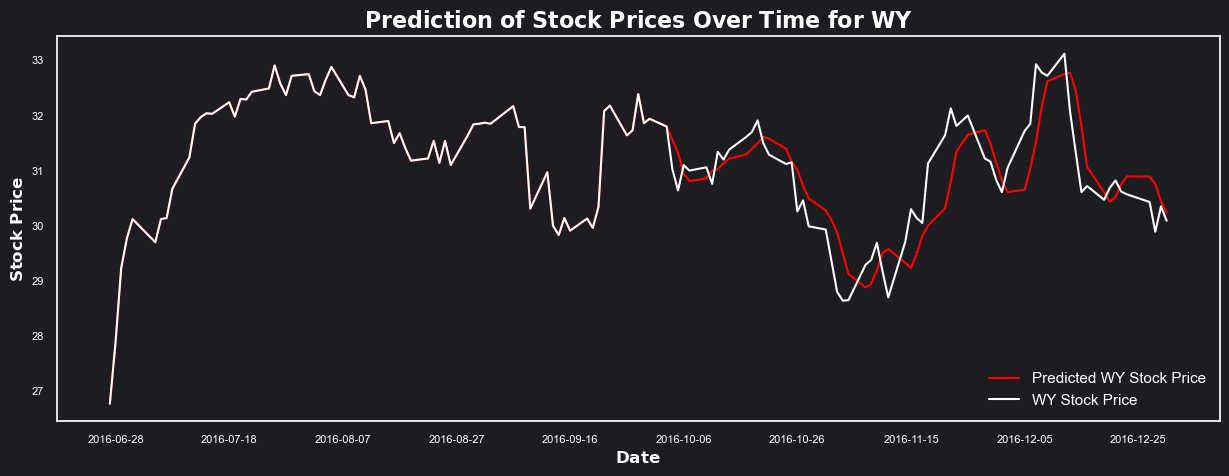

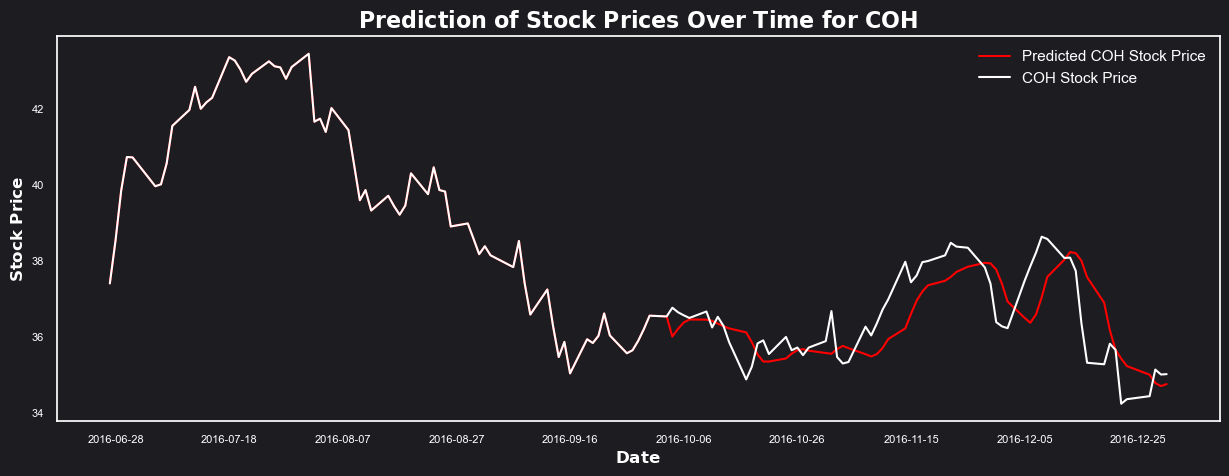

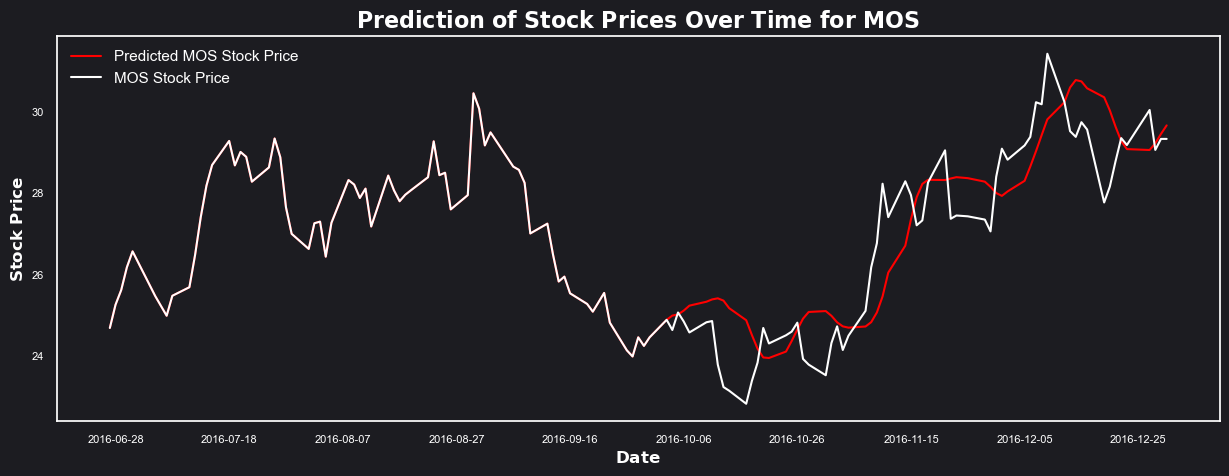

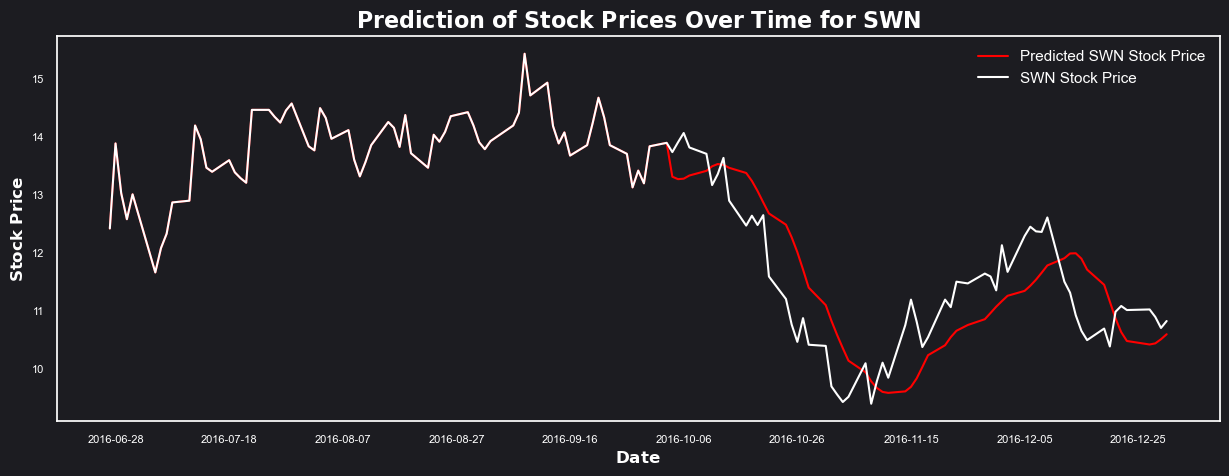

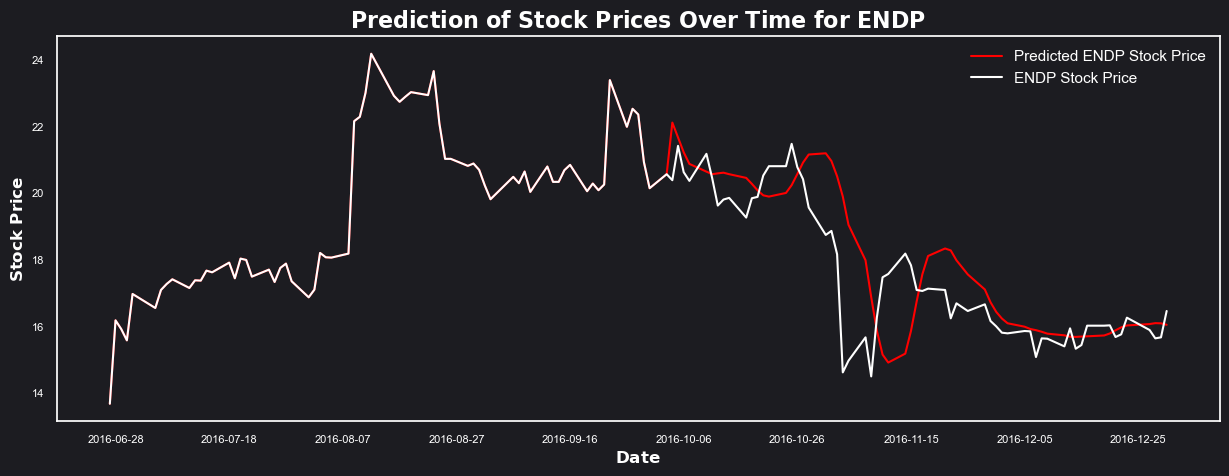

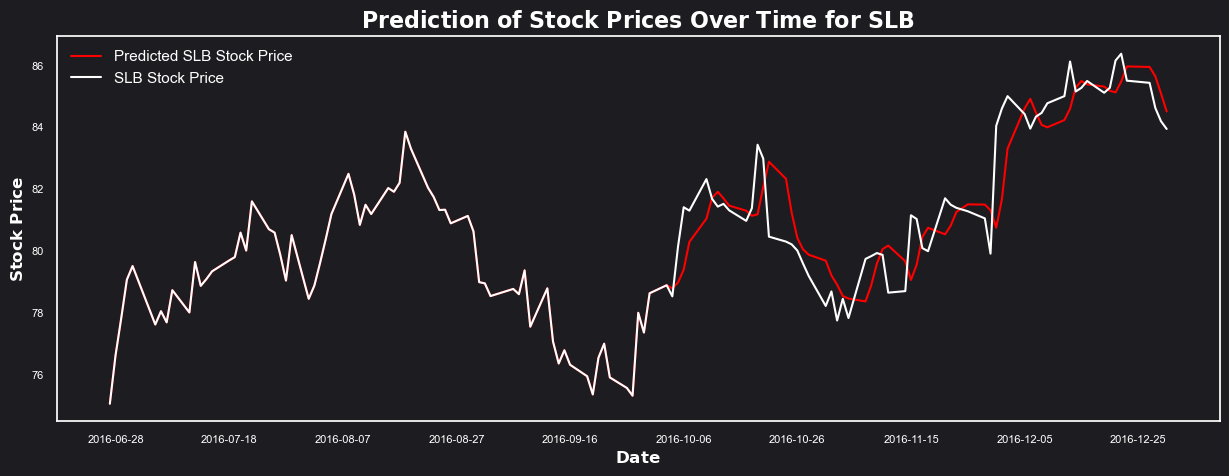

In [44]:
if (prediction==False):
    loss_rmse_df = pd.read_csv('loss.csv')
    predicted_prices_df = pd.read_csv('predicted_prices.csv')
    full_with_predicted = pd.concat([prices_sa_train,predicted_prices_df])
    
plotting_stocklist = ['AAPL','GOOGL','RIG','FSLR','WFM','FCX','TDC','WY','COH','MOS','SWN','ENDP','SLB'] ## This is an arbitrary way to visualise the stocks
for name in plotting_stocklist:
    plt.figure(figsize=(15, 5), facecolor='#1C1C21')
    full_with_predicted.index = prices_sa_total.index
    sns.lineplot(x= full_with_predicted.iloc[1631:].index, y= full_with_predicted[name].iloc[1631:], data= full_with_predicted[name].iloc[1631:], label=f'Predicted {name} Stock Price', color='red')
    sns.lineplot(x= prices_sa_total.iloc[1631:].index, y= prices_sa_total[name].iloc[1631:], data= prices_sa_total[name].iloc[1631:], label=f'{name} Stock Price', color='white')   
    sns.set_style("dark")
    plt.gca().set_facecolor('#1C1C21') # this is the color of medium hence using that as the background
    plt.gca().set_title(r'$\bf{Prediction\ of\ Stock\ Prices\ Over\ Time\ for\ ' + name + '}$', fontsize=16, color='white')  
    plt.xlabel(r'$\bf{Date}$', color='white')  
    plt.ylabel(r'$\bf{Stock\ Price}$', color='white') 
    legend = plt.legend()
    for text in legend.get_texts():
        text.set_color('white')
    legend.get_frame().set_facecolor('#1C1C21')  
    legend.get_frame().set_linewidth(0)
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=20))
    plt.xticks(rotation=0, color='white')  
    plt.tick_params(axis='x', which='both', labelsize=8, colors='white')
    plt.tick_params(axis='y', which='both', labelsize=8, colors='white') 
    plt.show()

### 5. Portfolio Optimization

#### 5.1 Expected Returns

In [45]:
predicted_returns = expected_returns.returns_from_prices(full_with_predicted) 
average_predicted_returns = expected_returns.mean_historical_return(full_with_predicted)
average_predicted_returns.name = "Predicted - E(R)"
average_predicted_returns = average_predicted_returns.transpose()
average_predicted_returns.to_frame()

,Predicted - E(R)
A,0.109569
AAL,0.385609
AAP,0.226187
AAPL,0.212452
ABC,0.175384
...,...
XRX,0.006397
YHOO,0.129564
YUM,0.140721
ZBH,0.082229


#### 5.2 Covariance Matrix

In [46]:
covariance_matrix = risk_models.fix_nonpositive_semidefinite(risk_models.sample_cov(prices_sa_pivoted), fix_method = "spectral") 
covariance_matrix

Ticker Symbol,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,...,XEL,XL,XLNX,XOM,XRAY,XRX,YHOO,YUM,ZBH,ZION
Ticker Symbol,,,,,,,,,,,,,,,,,,,,,
A,0.088689,0.054155,0.026321,0.031123,0.027794,0.026362,0.037473,0.042119,0.043408,0.034674,...,0.016196,0.040254,0.039517,0.030028,0.040931,0.047239,0.039425,0.032701,0.035238,0.056327
AAL,0.054155,0.237707,0.031814,0.032764,0.027160,0.025064,0.029208,0.043720,0.041070,0.035047,...,0.015550,0.043535,0.035155,0.020833,0.037357,0.044320,0.040898,0.033979,0.031591,0.061014
AAP,0.026321,0.031814,0.074676,0.015953,0.013670,0.015532,0.016669,0.020578,0.022500,0.019929,...,0.010555,0.020125,0.021398,0.013535,0.019310,0.023081,0.020977,0.022431,0.017831,0.028976
AAPL,0.031123,0.032764,0.015953,0.068754,0.014451,0.014241,0.020883,0.024759,0.027955,0.018199,...,0.008965,0.021838,0.021976,0.017273,0.020478,0.027274,0.024410,0.021991,0.020574,0.031203
ABC,0.027794,0.027160,0.013670,0.014451,0.044129,0.015866,0.016934,0.019507,0.018524,0.016478,...,0.008066,0.020468,0.016515,0.014379,0.019564,0.021579,0.020633,0.015788,0.017237,0.025035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XRX,0.047239,0.044320,0.023081,0.027274,0.021579,0.023447,0.033526,0.036463,0.039366,0.033598,...,0.014794,0.036215,0.037043,0.027973,0.033170,0.087561,0.032642,0.026819,0.030715,0.052154
YHOO,0.039425,0.040898,0.020977,0.024410,0.020633,0.018341,0.026019,0.032892,0.031101,0.026879,...,0.010326,0.027781,0.027691,0.020464,0.025997,0.032642,0.092532,0.025492,0.025247,0.034200
YUM,0.032701,0.033979,0.022431,0.021991,0.015788,0.016310,0.022851,0.027951,0.025481,0.022265,...,0.012177,0.024094,0.022036,0.018941,0.022263,0.026819,0.025492,0.059910,0.019705,0.034051


#### 5.3 Max Sharpe Portfolio

In [47]:
from collections import OrderedDict
max_sharpe_EF = EfficientFrontier(mu,covariance_matrix,weight_bounds=(0,1),verbose=True)
weights = max_sharpe_EF.max_sharpe()
cleaned_weights = max_sharpe_EF.clean_weights()
max_sharpe_EF.portfolio_performance(verbose=True)
max_sharpe_portfolio = {'Weight':cleaned_weights}
max_sharpe_portfolio = pd.DataFrame(max_sharpe_portfolio)
max_sharpe_portfolio

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 05 11:23:52 PM: Your problem has 468 variables, 5 constraints, and 0 parameters.


(CVXPY) Dec 05 11:23:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 05 11:23:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 05 11:23:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 05 11:23:53 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 05 11:23:53 PM: Compiling problem (target solver=OSQP).
(CVXPY) Dec 05 11:23:53 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Dec 05 11:23:53 PM: Applying reduction CvxAttr2Constr
(CVXPY) Dec 05 11:23:53 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Dec 05 11:23:53 PM: 

,Weight
A,0.0
AAL,0.0
AAP,0.0
AAPL,0.0
ABC,0.0
...,...
XRX,0.0
YHOO,0.0
YUM,0.0
ZBH,0.0


#### 5.4 Global Minimum Variance Portfolio 

In [48]:
min_risk_EF = EfficientFrontier(mu,covariance_matrix,weight_bounds=(0,1),verbose=True)
weights = min_risk_EF.min_volatility()
cleaned_weights = min_risk_EF.clean_weights()
min_risk_EF.portfolio_performance(verbose=True)
min_risk_portfolio = {'Weight':cleaned_weights}
min_risk_portfolio = pd.DataFrame(min_risk_portfolio)
min_risk_portfolio

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 05 11:23:56 PM: Your problem has 467 variables, 3 constraints, and 0 parameters.


(CVXPY) Dec 05 11:23:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 05 11:23:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 05 11:23:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 05 11:23:59 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 05 11:23:59 PM: Compiling problem (target solver=OSQP).
(CVXPY) Dec 05 11:23:59 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Dec 05 11:23:59 PM: Applying reduction CvxAttr2Constr
(CVXPY) Dec 05 11:23:59 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Dec 05 11:23:59 PM: 

,Weight
A,0.00000
AAL,0.00000
AAP,0.00000
AAPL,0.00000
ABC,0.02666
...,...
XRX,0.00000
YHOO,0.00000
YUM,0.00000
ZBH,0.00000


#### 5.5 Target Risk Portfolio

In [49]:
target_risk_EF = EfficientFrontier(mu,covariance_matrix,weight_bounds=(0,1),verbose=True)
weights = target_risk_EF.efficient_risk(0.13)
cleaned_weights = target_risk_EF.clean_weights()
target_risk_EF.portfolio_performance(verbose=True)
target_risk_portfolio = {'Weight':cleaned_weights}
target_risk_portfolio = pd.DataFrame(target_risk_portfolio)
target_risk_portfolio

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 05 11:24:01 PM: Your problem has 467 variables, 4 constraints, and 1 parameters.
(CVXPY) Dec 05 11:24:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 05 11:24:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 05 11:24:02 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 05 11:24:02 PM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 05 11:24:02 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Dec 05 11:24:02 PM: Apply

,Weight
A,0.0
AAL,0.0
AAP,0.0
AAPL,0.0
ABC,0.0
...,...
XRX,0.0
YHOO,0.0
YUM,0.0
ZBH,0.0


#### 5.6 Efficient Frontier

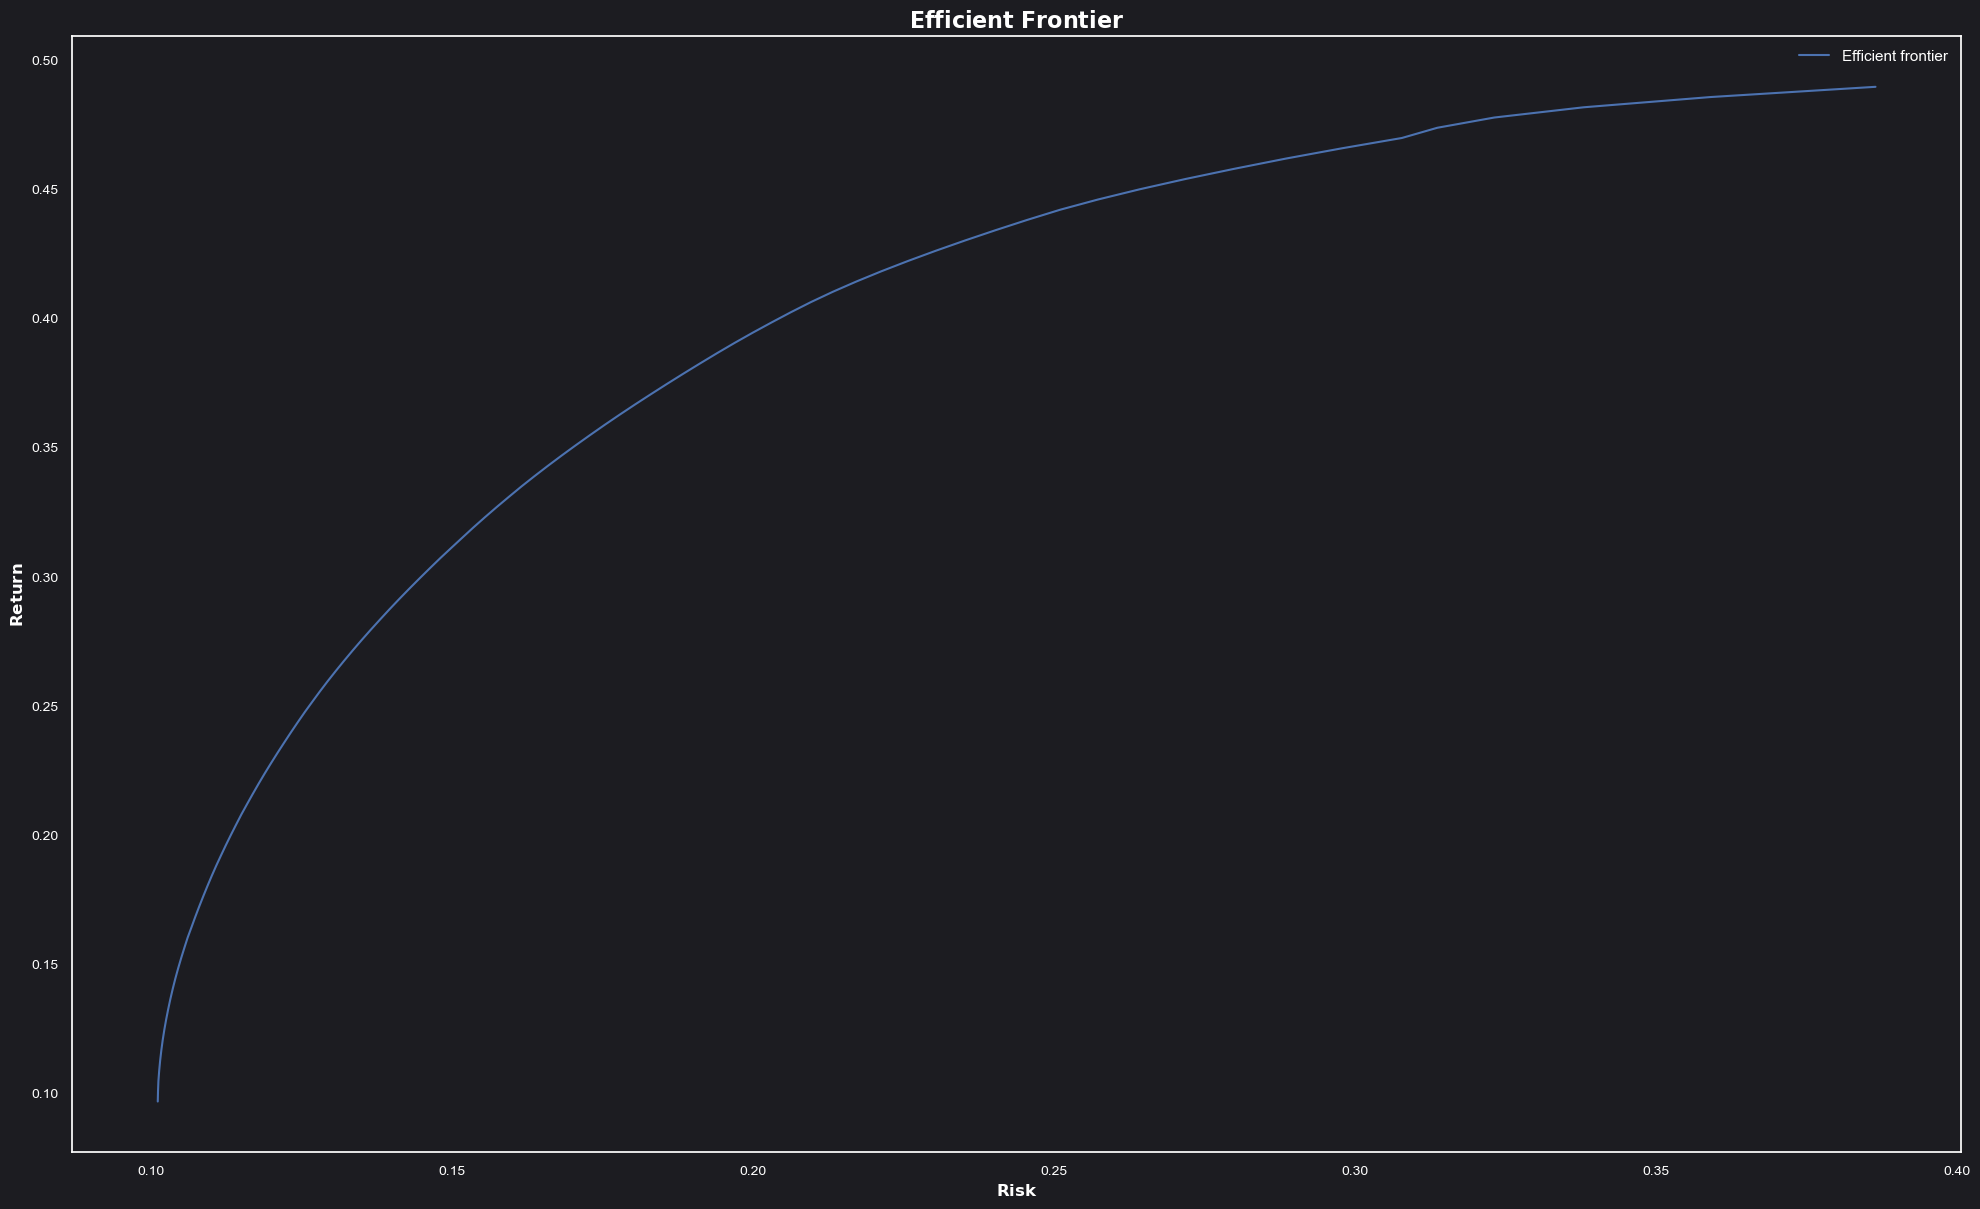

In [50]:
ef = EfficientFrontier(mu,covariance_matrix, weight_bounds=(0, 1))
fig, ax = plt.subplots(figsize=(20, 12), facecolor='#1C1C21')
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False,)

plt.gca().set_facecolor('#1C1C21') # this is the color of medium hence using that as the background
plt.gca().set_title(r'$\bf{Efficient\ Frontier}$', fontsize=16, color='white')  
plt.xlabel(r'$\bf{Risk}$', color='white')  
plt.ylabel(r'$\bf{Return}$', color='white') 
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('white')
legend.get_frame().set_facecolor('#1C1C21')  
legend.get_frame().set_linewidth(0)
plt.tick_params(axis='x', which='both', labelsize=10, colors='white')
plt.tick_params(axis='y', which='both', labelsize=10, colors='white')
plt.show()

## END OF PROJECT

# **MAY YOU GET RICH USING THIS MODEL**